## HT Correction V1
Detecting head-tail swap errors based on the change in tail position. If the change in tail position meets a certain threshold, then we can consider it an error. Through EDA, we see that there are certain peaks throughout the video which indicate potential error points where the head-tail coordinates swap.

In [2]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
from numpy import diff
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *

In [3]:
# original data
data = pd.read_csv('2021.09.08_12-49-52_W1118_Solvent/2021.09.08_12-49-52_data_processed.csv') 

In [15]:
# Filtering processed data
Xcentroid = pd.Series(data['X-Centroid'])
Ycentroid = pd.Series(data['Y-Centroid'])
Xhead = pd.Series(data['X-Head'])
Yhead = pd.Series(data['Y-Head'])
Xtail = pd.Series(data['X-Tail'])
Ytail = pd.Series(data['Y-Tail'])
frame = pd.Series(data['Frame'])

In [5]:
# Locate when larva is in center circle
binarized_array = []
for i in range(len(Xcentroid)):
    dist = (((Xcentroid[i] - 694)**2 + ((Ycentroid[i] - 486)**2))**(1/2))
    # print(dist)
    if dist > 85: # increased radius measurement for buffer room when larva is at very edge of circle
        binarized_array.append(0)
    else: 
        binarized_array.append(1)

In [6]:
# Function to find distance bewteen two frames
def dis(x1, y1, x2, y2):
    dist = (((x1-x2)**2 + (y1-y2)**2)**(1/2))
    return dist

In [7]:
# function to create change in tailPosition data
def tail_position_change(xt, yt, frame):
    tailPosition = []
    
    for i in range(frame[0]): # if frame doesn't start at 0
        tailPosition.append(0)
    
    for i in range(len(xt)-1):
        dist = dis(xt[i], yt[i], xt[i+1], yt[i+1])
        tailPosition.append(dist)
    
    return tailPosition

In [8]:
# function to make a plot for tailPosition data
def plot_tail_change(tail_data):
    xlist = np.linspace(frame[0], frame[0]+len(tail_data), len(tail_data)) # frames as x
    ylist = tail_data # change in tail position as y

    fig, ax = plt.subplots()
    ax.plot(xlist, ylist, linewidth=2.0)

    plt.show()

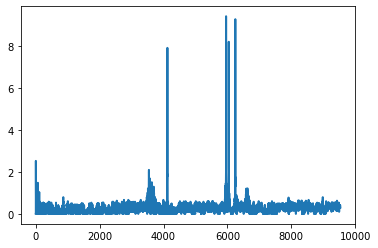

In [9]:
tchange = tail_position_change(Xtail, Ytail, frame)
tchange_plot = plot_tail_change(tchange)

#### Notes
- Not all big peaks are within the circle 
- ex) at frame 4119 it's not in the circle AND it doesn't curl BUT it swaps back itself at 4222 
    - 4119 is accounted as a big peak but 4222 is not (how will we detect that it switched back)?
- peaks > 4 identified at [4119, 5954, 6037, 6243] 
    - 4119 -> swaps ht creating error (then it's get fixed at 4218) -> not detectable in head position data too
        - tried looking if unprocessed data had any answers to why 4222 doesn't show up as big peak
    - 5956 - 6039 -> starts with ht error and ends with ht error (in between it swaps multiple times)
        - multiple switches aren't caught in data (tail position change distance) 
    - 6245 -> fixes ht error from 6037
- at 6037 it's on the edge of the circle -> need to widen circle range to include that

#### Suggestions
- use peaks as markers 
  - find 5 or 10 frames before then apply it to next 10-15 frames
- what if i try if both change in head and tail position are above certain threshold then that is a "peak"
    - rids of the error where tail position is just stretching out

#### Main Questions
- why isn't 4222 accounted for in tail position data?
- how can we group peaks like 5956 and 6039 which occur on the edge of the circle? 
    - rules out odd peaks switch method
    - check other plots to see if this occurs

In [10]:
# Find the peaks (relative max) CHECK THE OUTPUT
peaks = (diff(sign(diff(tchange))) < 0).nonzero()[0] + 1 # local max

In [11]:
# Find peaks greater than threshold (temporarily set at 4)
big_peaks = []
for frame in peaks:
    if tchange[frame] > 4:
        big_peaks.append(frame)
        
big_peaks

[4119, 5956, 6039, 6245]

In [12]:
# Find peaks INSIDE the circle
peaks_in_circle = []
for i in range(len(binarized_array)):
    if (binarized_array[i] == 1) and (i in peaks):
        peaks_in_circle.append(i)

# Find peaks INSIDE the circle that are greater than threshold (temporarily set at 4)
big_peaks1 = []
for frame in peaks_in_circle:
    if tchange[frame] > 4:
        big_peaks1.append(frame)
        
big_peaks1

[5956, 6039, 6245]

In [13]:
# take in the file, the peak (array of peaks we need to check), 
def ht_correction(peak, xc, yc, xh, yh, xt, yt, frame):
    xheadCorrected = xh.copy()
    yheadCorrected = yh.copy()
    xtailCorrected = xt.copy()
    ytailCorrected = yt.copy()
    
    # plot change in tail position without corrections
    tchange = tail_position_change(xt, yt, frame)
    tchange_plot = plot_tail_change(tchange)
    
    # test for HT correction
    def ht_error_correction(fr1, fr2, j):
        d1 = dis(xc[fr1], yc[fr1], xc[fr2], yc[fr2])
        d2 = dis(xc[fr1], yc[fr1], xt[fr2], yt[fr2])
        
        if d1 < d2: # CHECK THIS!!! i need to change it for the peak and AFTER it
            xheadCorrected[peak[j]:peak[j]+15] = xt[peak[j]:peak[j]+15]
            yheadCorrected[peak[j]:peak[j]+15] = yt[peak[j]:peak[j]+15]
            xtailCorrected[peak[j]:peak[j]+15] = xh[peak[j]:peak[j]+15]
            ytailCorrected[peak[j]:peak[j]+15] = yh[peak[j]:peak[j]+15]
            
            #print(xheadCorrected[fr1:fr2])
    
    for n in range(len(peak)):
        ht_error_correction(peak[n]-15, peak[n], n)
        #xheadCorrected = list(np.round(xheadCorrected,decimals = 1))
        #yheadCorrected = list(np.round(yheadCorrected, decimals=1))
        #xtailCorrected = list(np.round(xtailCorrected, decimals=1))
        #ytailCorrected = list(np.round(ytailCorrected, decimals=1))
    
    # plot change in tail position WITH corrections
    tchange1 = tail_position_change(xtailCorrected, ytailCorrected, frame)
    tchange_plot1 = plot_tail_change(tchange1)
    
    # finding peaks (if any) in the new set
    peaks = (diff(sign(diff(tchange1))) < 0).nonzero()[0] + 1
    
    new_peaks = []
    for frame in peaks:
        if tchange1[frame] > 4:
            new_peaks.append(frame)
        
    print(new_peaks)

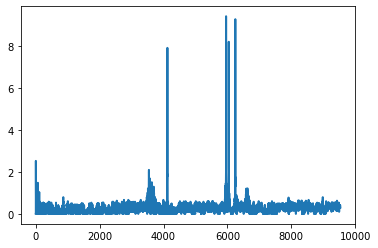

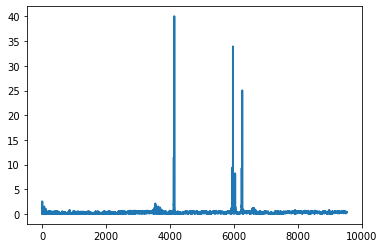

[4120, 4135, 5956, 5972, 6039, 6245, 6261]


In [16]:
ht_correction(big_peaks, Xcentroid, Ycentroid, Xhead, Yhead, Xtail, Ytail, frame)

In [17]:
# Manually testing function 
d1 = dis(Xcentroid[big_peaks[0]-15], Ycentroid[big_peaks[0]-15], Xcentroid[big_peaks[0]], Ycentroid[big_peaks[0]])
d2 = dis(Xcentroid[big_peaks[0]-15], Ycentroid[big_peaks[0]-15], Xtail[big_peaks[0]], Ytail[big_peaks[0]])

print(d1, d2)

# Manually fix from 4119 to 4218

xheadCorrected = Xhead.copy()
yheadCorrected = Yhead.copy()
xtailCorrected = Xtail.copy()
ytailCorrected = Ytail.copy()

xheadCorrected[4119:4218] = Xtail[4119:4218]
yheadCorrected[4119:] = Ytail[4119:]
xtailCorrected[4119:4218] = Xhead[4119:4218]
ytailCorrected[4119:4218] = Yhead[4119:4218]


1.0198039027185435 6.306346010171034


In [18]:
# Test if peak has HT error
d1 = dis(Xcentroid[4104], Ycentroid[4104], Xtail[4119], Ytail[4119])
d2 = dis(Xcentroid[4104], Ycentroid[4104], Xhead[4119], Yhead[4119])
if d1 < d2:
    print("It's ok")
else:
    print("There's an error")
    
print(d1, d2)

It's ok
6.306346010171034 8.920201791439387


### TESTING PLOTS

In [82]:
data1 = pd.read_csv('2021.10.04_15-08-01_W1118 Odor/2021.10.04_15-08-01_data_processed.csv') 

In [83]:
# Filtering processed data
XC1 = pd.Series(data1['X-Centroid'])
YC1 = pd.Series(data1['Y-Centroid'])
XH1 = pd.Series(data1['X-Head'])
YH1 = pd.Series(data1['Y-Head'])
XT1 = pd.Series(data1['X-Tail'])
YT1 = pd.Series(data1['Y-Tail'])
frame1 = pd.Series(data1['Frame'])

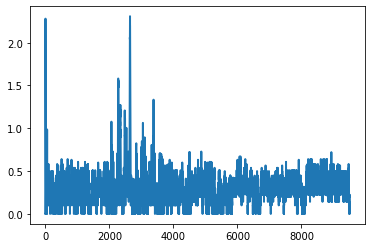

In [84]:
tchange1 = tail_position_change(XT1, YT1, frame1)
plot_tail_change(tchange1) 

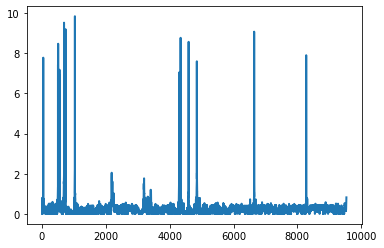

In [90]:
data2 = pd.read_csv('2021.09.09_12-51-26_W1118_Odor/2021.09.09_12-51-26_data_processed.csv')

# Filtering processed data
XC2 = pd.Series(data2['X-Centroid'])
YC2 = pd.Series(data2['Y-Centroid'])
XH2 = pd.Series(data2['X-Head'])
YH2 = pd.Series(data2['Y-Head'])
XT2 = pd.Series(data2['X-Tail'])
YT2 = pd.Series(data2['Y-Tail'])
frame2 = pd.Series(data2['Frame'])

tchange2 = tail_position_change(XT2, YT2, frame2)
plot_tail_change(tchange2)

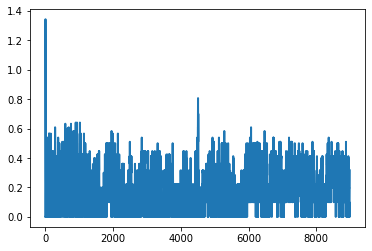

In [91]:
data3 = pd.read_csv('2021.07.26_23-28-46_test/2021.07.26_23-28-46_data_processed.csv') 

# Filtering processed data
XC3 = pd.Series(data3['X-Centroid'])
YC3 = pd.Series(data3['Y-Centroid'])
XH3 = pd.Series(data3['X-Head'])
YH3 = pd.Series(data3['Y-Head'])
XT3 = pd.Series(data3['X-Tail'])
YT3 = pd.Series(data3['Y-Tail'])
frame3 = pd.Series(data3['Frame'])

tchange3 = tail_position_change(XT3, YT3, frame3)
plot_tail_change(tchange3)

### DIFFERENT APPROACH

In [19]:
up_data = pd.read_csv('2021.09.08_12-49-52_W1118_Solvent/2021.09.08_12-49-52_data.csv')

In [20]:
up_Xcentroid = pd.Series(up_data['X-Centroid'])
up_Ycentroid = pd.Series(up_data['Y-Centroid'])
up_Xhead = pd.Series(up_data['X-Head'])
up_Yhead = pd.Series(up_data['Y-Head'])
up_Xtail = pd.Series(up_data['X-Tail'])
up_Ytail = pd.Series(up_data['Y-Tail'])
up_frame = pd.Series(up_data['Frame'])

In [24]:
# Find all points when centroid = head = tail
flags = []
for i in range(len(up_Xcentroid)):
    if (up_Xcentroid[i] == up_Xhead[i] == up_Xtail[i] != 0) and (up_Ycentroid[i] == up_Yhead[i] == up_Ytail[i] != 0):
        flags.append(i)

# Attempting to remove the continuous points
proc_flags = []
for i in range(len(flags)-1):
    if flags[i+1] != flags[i] + 1:
        proc_flags.append(flags[i])
        
flags

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 39,
 40,
 58,
 60,
 61,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 73,
 79,
 82,
 85,
 86,
 87,
 88,
 861,
 862,
 863,
 864,
 970,
 3498,
 3506,
 3512,
 3515,
 3516,
 3520,
 3523,
 3524,
 3525,
 3526,
 3528,
 3533,
 3542,
 3543,
 3546,
 3553,
 3555,
 3561,
 3577,
 3587,
 3599,
 3606,
 3609,
 3613,
 3614,
 3617,
 3628,
 3630,
 3634,
 3635,
 3637,
 3638,
 3642,
 3645,
 3648,
 3649,
 3653,
 3656,
 3657,
 3662,
 3664,
 3665,
 3666,
 3668,
 3671,
 3672,
 3673,
 3674,
 3675,
 3676,
 3677,
 3685,
 3686,
 3687,
 3692,
 3694,
 3695,
 3696,
 3697,
 3698,
 3699,
 3701,
 3705,
 3708,
 3712,
 3715,
 3717,
 3718,
 3721,
 3723,
 3724,
 3732,
 4118,
 5957,
 5963,
 5965,
 5966,
 5968,
 5976,
 5990,
 5995,
 5996,
 5997,
 5998,
 6000,
 6016,
 6017,
 6019,
 6020,
 6022,
 6023,
 6024,
 6025,
 6033,
 6035,
 6036,
 6038,
 6248,
 626

In [22]:
#proc_flags

In [23]:
# Find all points that are actually errors (using flags and applying to PROCESSED data)
error_flags = []
for i in proc_flags:
    if i < 2: 
        continue 
    
    # check one after and closest one before that is NOT in flags
        
    d1 = dis(Xtail[i-1], Ytail[i-1], Xtail[i+1], Ytail[i+1])
    d2 = dis(Xcentroid[i], Ycentroid[i], Xtail[i-1], Ytail[i-1])
    
    if d1 > d2:
        error_flags.append(i)

#error_flags


In [121]:
d1 = dis(Xcentroid[16-15], Ycentroid[16-15], Xcentroid[16], Ycentroid[16])
d2 = dis(Xcentroid[16-15], Ycentroid[16-15], Xtail[16], Ytail[16])
print(d1, d2)

1.8027756377320183 2.816025568065748
